In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/celebrity_profiling_training_after_preprocessing.csv


In [3]:
!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 90 kB 2.6 MB/s 


In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.
UsageError: Line magic function `%` not found.


In [5]:
from nltk.tokenize import word_tokenize
!pip install pyspellchecker
from spellchecker import SpellChecker
import time
from multiprocessing import  Pool


     |████████████████████████████████| 1.9 MB 3.3 MB/s 


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [7]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/celebrity_profiling_training_after_preprocessing.csv


## Load Dataset


In [8]:
df = pd.read_csv("/kaggle/input/celebrity_profiling_training_after_preprocessing.csv", sep=',')
#, header=None, names=['sentence_source', 'label', 'label_notes', 'sentence']

In [9]:
df=df.dropna()

In [10]:
df.shape

(132693, 4)

In [11]:
df.head()

,birthyear,gender,occupation,text
0,1997.0,1.0,3.0,dota 2 livestream india pro dota 2 india gamep...
1,1997.0,1.0,3.0,rt jhbteam this 80 is sex ed psa has me crying...
2,1997.0,1.0,3.0,"rt 33whitten i am really proud of me team, bun..."
3,1997.0,1.0,3.0,rt wildanimalssr missed out on the best first ...
4,1997.0,1.0,3.0,"rt evilgeniuses the setup, the rampage, the go..."


In [12]:
df.tail()

,birthyear,gender,occupation,text
132808,1947.0,0.0,1.0,sleeping
132809,1947.0,0.0,1.0,since the two child policy took effect 75 of c...
132810,1947.0,0.0,1.0,looking for a new romance to read? check out l...
132811,1947.0,0.0,1.0,its aimbot 3rd seed?
132812,1947.0,0.0,1.0,pfrumors


In [13]:
# Create sentence and label lists
sentences = df.text.values

In [14]:
sentences[1]

'rt jhbteam this 80 is sex ed psa has me crying lmfaoooooo url'

In [15]:
sentences[1]

'rt jhbteam this 80 is sex ed psa has me crying lmfaoooooo url'

In [16]:
# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
labels=df['occupation'].values

In [17]:
labels=[int(i) for i in labels]

In [18]:
set(labels)

{0, 1, 2, 3}

## Inputs

In [19]:
sentences[3]

'[CLS] rt wildanimalssr missed out on the best first marathon of 2020? check it all out on our youtizzle now url [SEP]'

In [20]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[1])

100%|██████████| 231508/231508 [00:00<00:00, 2545755.86B/s]


Tokenize the first sentence:
['[CLS]', 'rt', 'j', '##h', '##bt', '##ea', '##m', 'this', '80', 'is', 'sex', 'ed', 'ps', '##a', 'has', 'me', 'crying', 'l', '##m', '##fa', '##oo', '##oo', '##oo', 'ur', '##l', '[SEP]']


In [21]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [22]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids= [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [23]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


Create the attention masks 

In [24]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [25]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.03)
train_masks, test_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.03)

train_masks, validation_masks, _, _ = train_test_split(train_masks, train_inputs,
                                             random_state=2018, test_size=0.03)

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_inputs, train_labels, 
                                                            random_state=2018, test_size=0.03)



In [26]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)




In [27]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

testing_data = TensorDataset(test_inputs, test_masks, test_labels)
testing_sampler = SequentialSampler(testing_data)
testing_dataloader = DataLoader(testing_data, sampler=testing_sampler, batch_size=batch_size)

In [28]:
train_inputs

tensor([[  101,  1054, 14204,  ...,     0,     0,     0],
        [  101,  3680,  5558,  ...,     0,     0,     0],
        [  101,  2957, 10024,  ...,     0,     0,     0],
        ...,
        [  101, 10654,  6238,  ...,     0,     0,     0],
        [  101,  2053,  5974,  ...,     0,     0,     0],
        [  101, 11307,  4890,  ...,     0,     0,     0]])

## Train Model

In [29]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

#model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)
model.cuda()

100%|██████████| 407873900/407873900 [00:09<00:00, 44569767.06B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [30]:

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]



In [31]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

In [32]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [33]:
from sklearn.metrics import f1_score


In [34]:
# Function to calculate the accuracy of our predictions vs labels
def f1_weighted(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(pred_flat, labels_flat, average='weighted')

In [35]:
def f1_macro(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(pred_flat, labels_flat, average='macro')

In [36]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# Function to calculate the accuracy of our predictions vs labels
def precision(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return precision_score(pred_flat, labels_flat, average='macro')


# Function to calculate the accuracy of our predictions vs labels
def recall1(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return recall_score(pred_flat, labels_flat, average='macro')

In [37]:
from sklearn.metrics import f1_score

t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []
pred_flat_list=[]
labels_flat_list=[]

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()
  
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
    
    
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy,F1_score, F2_score = 0, 0 , 0.0 , 0.0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
          # Forward pass, calculate logit predictions
          logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
            
        f1 = f1_macro(logits, label_ids)

        f2 = f1_weighted(logits, label_ids)
        
        F1_score+=f1
        F2_score+=f2
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
        
    print("F1 score(macro): {}".format(F1_score/nb_eval_steps))
    print("F1 score(weighted): {}".format(F2_score/nb_eval_steps))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 1.1771598346321355


Epoch:  25%|██▌       | 1/4 [31:52<1:35:37, 1912.59s/it]

F1 score(macro): 0.4438069879921031
F1 score(weighted): 0.5417971589159956
Validation Accuracy: 0.5257090533433508
Train loss: 1.0514023159021968


Epoch:  50%|█████     | 2/4 [1:03:46<1:03:46, 1913.00s/it]

F1 score(macro): 0.4629708529779208
F1 score(weighted): 0.540069567231429
Validation Accuracy: 0.5328230653643876
Train loss: 0.9747688271399341


Epoch:  75%|███████▌  | 3/4 [1:35:39<31:53, 1913.12s/it]  

F1 score(macro): 0.4517591534205825
F1 score(weighted): 0.5521984020933809
Validation Accuracy: 0.5365561607813674
Train loss: 0.9219482366639122


Epoch: 100%|██████████| 4/4 [2:07:35<00:00, 1913.76s/it]

F1 score(macro): 0.470285937517743
F1 score(weighted): 0.5353122331562659
Validation Accuracy: 0.5306160781367393


## Training Evaluation

Let's take a look at our training loss over all batches:

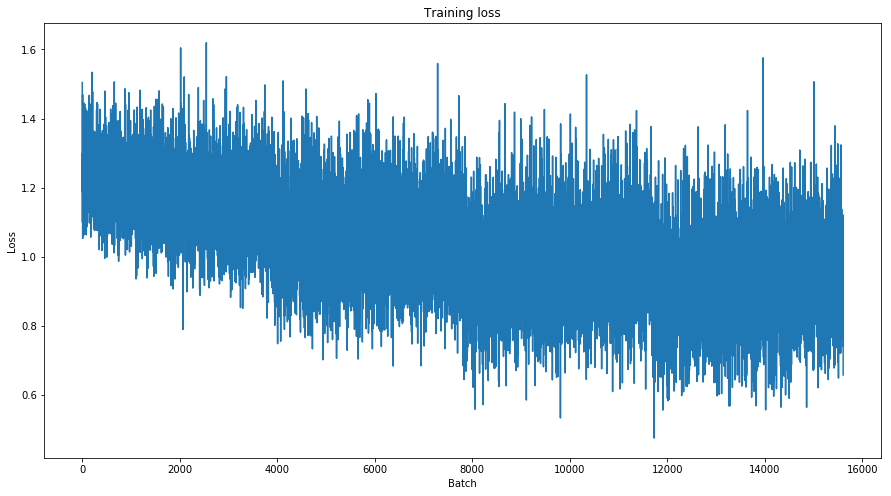

In [38]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()